In [3]:
import numpy as np
import pandas as pd
import statsmodels
import scipy as sc
from statsmodels.stats.weightstats import *
from pandas.tools.plotting import scatter_matrix
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Загрузка данных и краткий обзор

In [4]:
data = pd.read_csv('credit_card_default_analysis.csv', index_col=0)

In [5]:
data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,0,0,0,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,0,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,0,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [6]:
data.shape

(30000, 24)

In [7]:
data.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.00000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,0.356767,0.320033,0.304067,0.258767,0.22150,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,0.760594,0.801727,0.790589,0.761113,0.71772,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.00000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


Сравним численность людей, вернувших кредит, и не вернувших его.

In [8]:
data.default.value_counts()

0    23364
1     6636
Name: default, dtype: int64

## Вспомогательные методы

In [9]:
def make_hist_target_by_category(data, factor, names, width=0.3):
    group0 = np.bincount(data[data['default'] == 0][factor].astype('int32').values)
    group1 = np.bincount(data[data['default'] == 1][factor].astype('int32').values)
    
    if group0[0] == 0 and group1[0] == 0:
        group0 = group0[1:]
        group1 = group1[1:]
    
    ind = np.arange(2) 
    fig, ax = plt.subplots()
    rects_data = []
    cmap = plt.get_cmap('Spectral')
    colors = cmap(np.linspace(0, len(group0)))
    for i in xrange(len(group0)):   
        rects = ax.bar(ind + i*width, (group0[i], group1[i]), width, color=colors[i])
        rects_data.append(rects)
        
    ax.set_ylabel('Amount')
    ax.set_title('Histogram of clients by ' + factor)
    ax.set_xticks(ind + width * (len(group0)) / float(2))
    ax.set_xticklabels(('default == 0', 'default == 1'))
       
    ax.legend(tuple(rects[0] for rects in rects_data), names)
        
    for rects in rects_data:
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.05*height, '%d' % int(height),ha='center', va='bottom')
    plt.show()

In [10]:
def make_hist_category_by_target(data, factor, names, width=0.3):    
    group0 = np.bincount(data[data['default'] == 0][factor].astype('int32').values)
    group1 = np.bincount(data[data['default'] == 1][factor].astype('int32').values)
    
    if group0[0] == 0 and group1[0] == 0:
        group0 = group0[1:]
        group1 = group1[1:]
    
    ind = np.arange(len(group0))

    fig, ax = plt.subplots()
    rects1 = ax.bar(ind, tuple(group0), width, color='r')
    rects2 = ax.bar(ind + width, tuple(group1), width, color='y')
 
    ax.set_ylabel('Amount')
    ax.set_title('Histogram of clients by ' + factor)
    ax.set_xticks(ind + width)
    ax.set_xticklabels(names)

    ax.legend((rects1[0], rects2[0]), ('default == 0', 'default == 1'))


    def autolabel(rects):        
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                    '%d' % int(height),
                    ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    plt.show()

In [11]:
def make_hist_numerical(data, factor, rng, bins=10):
    pylab.figure(figsize(12, 5))
    pylab.subplot(1,2,1)
    pylab.hist(data[data['default'] == 0][factor], bins = bins, color = 'b', range = rng, 
               label = 'default == 0')
    pylab.legend()

    pylab.subplot(1,2,2)
    pylab.hist(data[data['default'] == 1][factor], bins = bins, color = 'r', range = rng, 
               label = 'default == 1')
    pylab.legend()

    pylab.show()

In [12]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [13]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [14]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [15]:
def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [16]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [17]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [18]:
def proportions_confint_diff_ind(a1, n1, a2, n2, alpha = 0.05):    
    z = sc.stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(a1) / n1
    p2 = float(a2) / n2
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ n1 + p2 * (1 - p2)/ n2)
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ n1 + p2 * (1 - p2)/ n2)
    
    return (left_boundary, right_boundary)

In [19]:
def proportions_diff_z_stat_ind(a, n1, b, n2):        
    p1 = float(a) / n1
    p2 = float(b) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [20]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - sc.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return sc.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - sc.stats.norm.cdf(z_stat)

## Задание 1. Размер кредитного лимита (LIMIT_BAL)

Рассмотрим 2 группы людей - тех, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1).
Построим гистограммы распределения размера кредитного лимита в обеих группах.

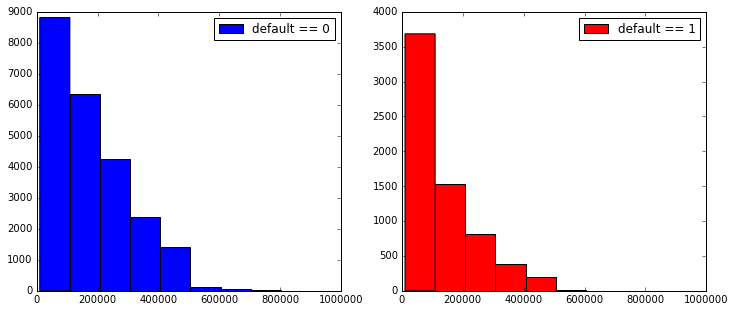

In [21]:
make_hist_numerical(data, 'LIMIT_BAL', (10000, 1000000), bins=10)

По гистограммам можно оценить, что по каждому интервалу кредитного лимита людей, вернувших кредит больше, чем не вернувших.

### Проверим гипотезу о равенстве медианных значений кредитного лимита против общей альтернативы:

$H_0\colon$ медианы значений кредитных лимитов в двух группах равны между собой

$H_1\colon$ медианы значений кредитных лимитов в двух группах не равны между собой

Воспользуемся интервальной оценкой. Посчитаем 95%-ый доверительный интервал разности медианных значений в двух выборках с помощью bootstrap.

In [22]:
limit_bal0 = data[data['default'] == 0]['LIMIT_BAL'].values
limit_bal1 = data[data['default'] == 1]['LIMIT_BAL'].values

In [23]:
np.random.seed(0)
limit_bal0_median_scores = map(np.median, get_bootstrap_samples(limit_bal0, 1000))
limit_bal1_median_scores = map(np.median, get_bootstrap_samples(limit_bal1, 1000))
delta_median_scores = map(lambda x: x[0] - x[1], zip(limit_bal0_median_scores, limit_bal1_median_scores))
print "95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05)

95% confidence interval for the difference between medians [ 60000.  70000.]


95%-ый доверительный интервал для разности медиан не содержит 0, следовательно нулевая гипотеза отвергается в пользу альтернативы о неравенстве медиан.

### Проверим гипотезу о равенстве распределений значения LIMIT_BAL
$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

Применим перестановочный критерий.
Необходимое условие для его применения - приблизительное равенство дисперсий обеих выборок. В данном случае:

In [26]:
limit_bal0.std()**2 / limit_bal1.std()**2

1.301654480028692

Дисперсии ненамного отличаются (порядок одинаков), поэтому перестановочный критерий можно применять.

In [163]:
print "p-value: %f" % permutation_test(limit_bal0, limit_bal1, max_permutations = 10000)

p-value: 0.000100


Достигаемый уровень значимости заметно меньше 0.05, следовательно нулевая гипотеза о равенстве распределений отвергается в пользу альтернативы.

Полученный результат о неравенстве медиан довольно легко объяснить с точки зрения общей логики: если система принятия решений о выдаче кредита достаточно надежная, то наибольшие кредиты выдаются тем людям, в которых банк более всего уверен. Логично, что такие люди, как правило, возвращают кредит. И наоборот, те люди, которые не являются очень надежными с точки зрения банка тем не менее могут получить кредит, но как правило не очень большой. И среди них больше доля тех, кто кредит не вернет.

С практической точки зрения такой результат не имеет особой значимости, потому что в "обратную" сторону его, разумеется, применить нельзя: было бы абсурдно считать в качестве самостоятельного критерия суждение о том, что если выдать человеку большой кредит, то это повысит вероятность его возврата.

## Задание 2. Пол (SEX)

Построим гистограммы распределения полов среди вернувших и не вернувших кредит

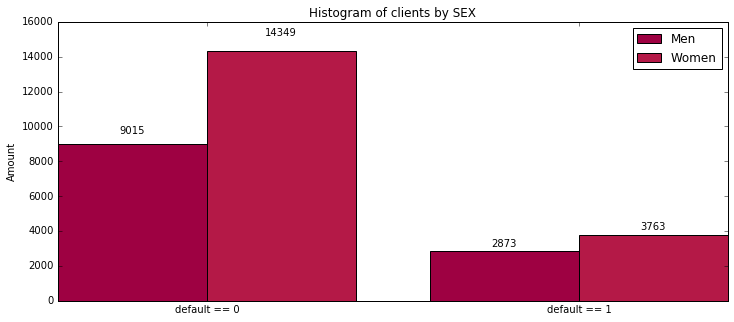

In [24]:
make_hist_target_by_category(data, 'SEX', ('Men', 'Women'), width=0.4)

По построенным гистограммам можно предположить, что гендерный состав отличается. Среди не вернувших кредит он более сбалансированный.
Численность можно представить также в таблице:

   | вернули кредит | не вернули кредит
  ------------- | -------------|
  мужчин  | 9015 | 2873 
  женщин  | 14349 | 3763 
  $\sum$ | 23364 | 6636

Будем проверять гипотезу

$H_0\colon $ гендерный состав людей, вернувших и не вернувших кредит, не отличается

$H_1\colon $ гендерный состав отличается

Построим доверительный интервал для разности долей (выборки независимы). Будем рассматривать долю мужчин среди вернувших и не вернувших кредит клиентов.

In [25]:
sex0 = np.bincount(data[data['default'] == 0]['SEX'].astype('int32').values)
sex1 = np.bincount(data[data['default'] == 1]['SEX'].astype('int32').values)
print "confidence interval: [%f, %f]" % proportions_confint_diff_ind(sex0[1], sum(sex0), sex1[1], sum(sex1))

confidence interval: [-0.060548, -0.033635]


Доверительный интервал для разности долей не содержит нуля, следовательно, можно отвергнуть гипотезу о равернстве доли мужчин среди вернувших и не вернувших кредит. Таким образом, гендерный состав отличается.

Теперь проверим ту же гипотезу с помощью Z-критерия. Ограничением для его применения является наличие в выборке только двух типов значений. Это условие выполнено.

In [26]:
proportions_diff_z_test(proportions_diff_z_stat_ind(sex0[1], sum(sex0), sex1[1], sum(sex1)))

4.4728665216098307e-12

Достигаемый уровень значимости сильно меньше 0.05, поэтому гипотеза о равенстве доли отвергается. Гендерный состав отличается.

## Задание 3. Образование (EDUCATION)

Построим гистограмму, показывающую соотношение людей, вернувших и не вернувших кредит в зависимости от уровня их образования.

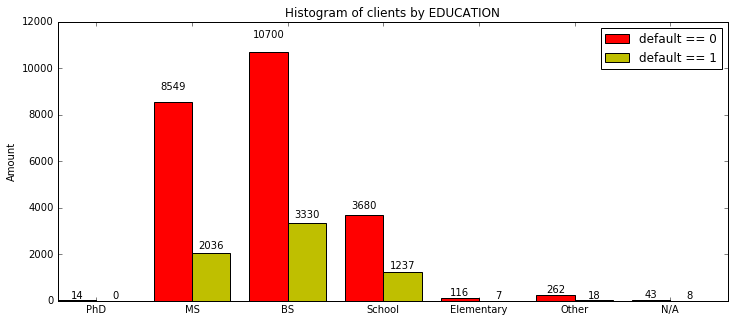

In [27]:
make_hist_category_by_target(data, 'EDUCATION', ('PhD', 'MS', 'BS', 'School', 'Elementary', 'Other', 'N/A'), 
                             width=0.4)

По гистограмме можно сделать предположение, что среди людей с более высоким уровнем образования доля тех, кто не вернул кредит, меньше.

Проверяем гипотезу

$H_0\colon $ уровень образования не влияет на возврат долга

$H_1\colon $ уровень образования влияет на возврат долга

Составим таблицу сопряженности "образование" на "возврат долга"

   | вернули кредит | не вернули кредит
  ------------- | -------------|
  доктор  | 14 | 0 
  магистр  | 8549 | 2036 
  бакалавр  | 10700 | 3330 
  выпускник школы | 3680 | 1237 
  начальное образование  | 116 | 7 
  прочее  | 262 | 18 
  нет данных  | 43 | 8 
  $\sum$ | 23364 | 6636

Применим критерий Хи-квадрат. Это можно сделать, т.к. условия для его применимости выполняются: размер выборки больше 40, количество элементов в каждой ячейке таблицы меньше 5 не более, чем в 20% ячеек, выборки независимы.

In [28]:
conting = [[14, 0], [8549, 2036], [10700, 3330], [3680, 1237], [116, 7], [262, 18], [43, 8]]
chi2, p, dof, expected = sc.stats.chi2_contingency(conting)
p

1.2332626245415958e-32

Достигаемый уровень значимости сильно меньше 0.05, следовательно гипотеза $H_0$ отвергается. Уровень образования влияет на возврат долга.

Отобразим ожидаемое количество человек по описанным группам:

In [29]:
[(int(pair[0]), int(pair[1])) for pair in expected]

[(10, 3),
 (8243, 2341),
 (10926, 3103),
 (3829, 1087),
 (95, 27),
 (218, 61),
 (39, 11)]


Для наглядности составим также таблицу сопряженности, где значением ячейки будет разность между ожидаемым и наблюдаемым количеством человек, вернувших и не вернувших кредит, в зависимости от образования.

   | вернули кредит | не вернули кредит
  ------------- | -------------|
  доктор  | -4 | 3 
  магистр  | -306 | 305 
  бакалавр  | 226 | -227 
  выпускник школы | 149 | -150 
  начальное образование  | -21 | 20 
  прочее  | -44 | 43
  нет данных  | -4 | 3 
  $\sum$ | -4 | -3

Для того, чтобы привести таблицу к одному масштабу, ее можно нормализовать на количество клиентов в каждой группе.
Наилучшим индикатором того, что человек отдаст долг является образование на уровне доктора. Того, что не отдаст - уровень бакалавра или выпускника школы.

## Задание 4. Семейное положение (MARRIAGE)

Построим гистограмму, показывающую соотношение людей, вернувших и не вернувших кредит, в зависимости от их семейного статуса.

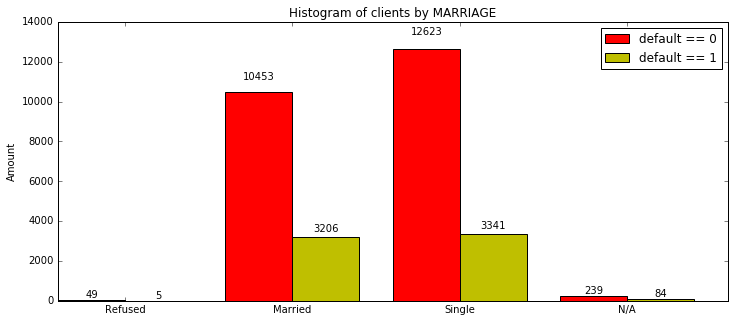

In [30]:
make_hist_category_by_target(data, 'MARRIAGE', ('Refused', 'Married', 'Single', 'N/A'), width=0.4)

По гистограмме можно сделать предположение, что среди холостых вероятность возврата кредита выше.

  Составим таблицу сопряженности "семейное положение" на "возврат долга"

   | вернули кредит | не вернули кредит
  ------------- | -------------|
  отказ  | 49 | 5 
  замужем/женат  | 10453 | 3206 
  холост  | 12623 | 3341 
  нет данных | 239 | 84 
  $\sum$ | 23364 | 6636

Для измерения возможной связи этих переменных посчитаем коэффициент V Крамера. Он основывается на критерии Хи-квадрат, для которого нужно проверить условия применимости - размер выборки больше 40, количество элементов в каждой ячейке таблицы меньше 5 не более, чем в 20% ячеек, выборки независимы. Эти условия выполняются.

In [31]:
conting = [[49, 5],[10453, 3206], [12623, 3341], [239, 84]]
chi2, p, dof, expected = sc.stats.chi2_contingency(conting)

v_c = np.sqrt(chi2 / (np.sum(conting) * (2-1)))
v_c

0.034478203662766466

Коэффициент V Крамера оказался довольно близок к 0, поэтому можно сделать вывод, что семейное положение не сильно влияет на возврат кредита.

## Задание 5. Возраст (AGE)

Рассмотрим 2 группы людей - тех, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1). Построим гистограммы распределения возраста в обеих группах.

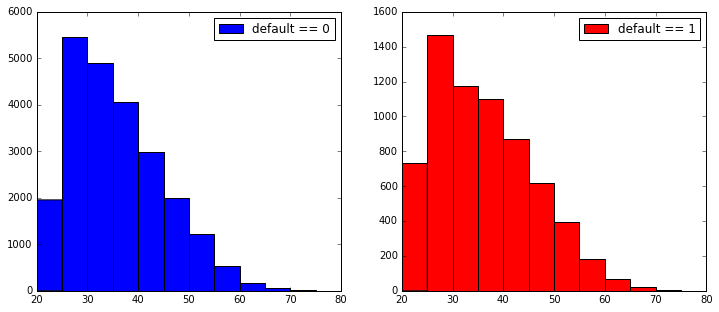

In [19]:
make_hist_numerical(data, 'AGE', (20, 80), bins=12)

По гистограммам можно оценить, что по каждому интервалу возрастов людей, вернувших кредит больше, чем не вернувших.

### Проверим гипотезу о равенстве медианных значений возрастов против общей альтернативы:

$H_0\colon$ медианы значений возрастов в двух группах равны между собой

$H_1\colon$ медианы значений возрастов в двух группах не равны между собой

Воспользуемся интервальной оценкой. Посчитаем 95%-ый доверительный интервал разности медианных значений в двух выборках с помощью bootstrap.

In [28]:
age0 = data[data['default'] == 0]['AGE'].values
age1 = data[data['default'] == 1]['AGE'].values

In [29]:
age0_median_scores = map(np.median, get_bootstrap_samples(age0, 5000))
age1_median_scores = map(np.median, get_bootstrap_samples(age1, 5000))
delta_age_median_scores = map(lambda x: x[0] - x[1], zip(age0_median_scores, age1_median_scores))
print "95% confidence interval for the difference between medians", stat_intervals(delta_age_median_scores, 0.05)

95% confidence interval for the difference between medians [-1.  0.]


95%-ый доверительный интервал для разности медиан граничит с 0, поэтому нулевую гипотезу нельзя однозначно отвергнуть.

### Проверим гипотезу о равенстве распределений значения AGE
$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

Применим перестановочный критерий. Необходимое условие для его применения - приблизительное равенство дисперсий обеих выборок. В данном случае:

In [30]:
age0.std()**2 / age1.std()**2

0.87702052085605231

Дисперсии ненамного отличаются (порядок одинаков), поэтому перестановочный критерий можно применять.

In [30]:
print "p-value: %f" % permutation_test(age0, age1, max_permutations = 10000)

p-value: 0.016300


Достигаемый уровень значимости меньше 0.05, следовательно нулевая гипотеза о равенстве распределений отвергается в пользу альтернативы.

Полученный результат обладает определенной практической значимостью, так как показывает, что среди более молодых людей оказалось больше тех, кто вернул кредит.

Для большей наглядности построим гистограмму числа людей, вернувших и не вернувших кредит, в зависимости от возраста. Для этого введем новый столбец "Возрастная категория"

In [82]:
def label_age(row):
    if row['AGE'] < 30:
        return 0
    elif row['AGE'] < 40:
        return 1
    elif row['AGE'] < 50:
        return 2
    elif row['AGE'] < 60:
        return 3
    elif row['AGE'] < 70:
        return 4    
    else:
        return 5   

In [84]:
data['age_cat'] = data.apply(lambda row: label_age(row),axis=1)

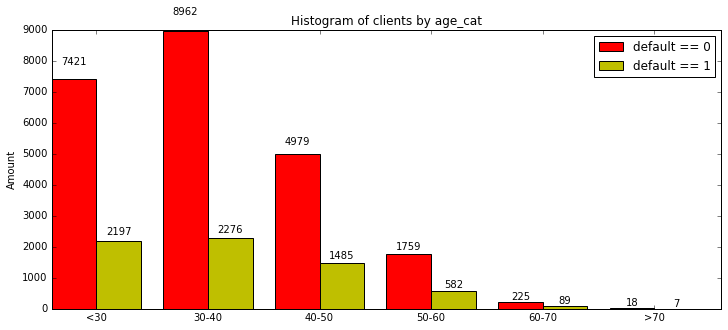

In [87]:
make_hist_category_by_target(data, 'age_cat', ('<30', '30-40', '40-50', '50-60', '60-70', '>70'), width=0.4)

Видно, что с увеличением возраста доля не вернувших кредит увеличивается.